This notebook saves all the data into pickle files.

In [1]:
import glob
from PIL import Image
import pickle
import numpy as np
# import torch
import xml.etree.ElementTree as ET

In [2]:
images_voc2012_train = glob.glob('./data/train/VOCdevkit/VOC2012/JPEGImages/*.jpg')
images_voc2007_train = glob.glob('./data/train/VOCdevkit/VOC2007/JPEGImages/*.jpg')
images_voc2012_test = glob.glob('./data/test/VOCdevkit/VOC2012/JPEGImages/*.jpg')
images_voc2007_test = glob.glob('./data/test/VOCdevkit/VOC2007/JPEGImages/*.jpg')
image_folders = [images_voc2012_train, images_voc2007_train, images_voc2012_test, images_voc2007_test]

annotations_voc2012_train = glob.glob('./data/train/VOCdevkit/VOC2012/Annotations/*.xml')
annotations_voc2007_train = glob.glob('./data/train/VOCdevkit/VOC2007/Annotations/*.xml')
annotations_voc2012_test = glob.glob('./data/test/VOCdevkit/VOC2012/Annotations/*.xml')
annotations_voc2007_test = glob.glob('./data/test/VOCdevkit/VOC2007/Annotations/*.xml')
annotation_folders = [annotations_voc2012_train, annotations_voc2007_train, 
                      annotations_voc2012_test, annotations_voc2007_test]

names = ['train_2012', 'train_2007', 'test_2012', 'test_2007']
classes =  np.array(['sheep', 'horse', 'bicycle', 'bottle', 'cow', 
                     'sofa', 'car', 'dog', 'cat', 'person', 'train', 
                     'diningtable', 'aeroplane', 'bus', 'pottedplant', 
                     'tvmonitor', 'chair', 'bird', 'boat', 'motorbike'])

In [3]:
%%bash
ls -la ./data/train/VOCdevkit/VOC2007/Annotations/*.xml | wc -l
ls -la ./data/train/VOCdevkit/VOC2012/Annotations/*.xml | wc -l
ls -la ./data/train/VOCdevkit/VOC2007/JPEGImages/*.jpg | wc -l
ls -la ./data/train/VOCdevkit/VOC2012/JPEGImages/*.jpg | wc -l

ls -la ./data/test/VOCdevkit/VOC2007/Annotations/*.xml | wc -l
ls -la ./data/test/VOCdevkit/VOC2012/Annotations/*.xml | wc -l
ls -la ./data/test/VOCdevkit/VOC2007/JPEGImages/*.jpg | wc -l
ls -la ./data/test/VOCdevkit/VOC2012/JPEGImages/*.jpg | wc -l

5011
17125
5011
17125
4952
5138
4952
16135


In [4]:
def parse_xml(xml_file):
    # actual parsing 
    in_file = open(xml_file)
    tree = ET.parse(in_file)
    root = tree.getroot()
    imsize = root.find('size')
    w = int(imsize.find('width').text)
    h = int(imsize.find('height').text)
    all_bboxes = list()

    for obj in root.iter('object'):
        current = list()
        name = obj.find('name').text

        class_id = np.argwhere(classes==name)[0][0]

        xmlbox = obj.find('bndbox')
        xn = int(float(xmlbox.find('xmin').text))
        xx = int(float(xmlbox.find('xmax').text))
        yn = int(float(xmlbox.find('ymin').text))
        yx = int(float(xmlbox.find('ymax').text))
        current = np.array([class_id,xn,yn,xx,yx])
        all_bboxes += [current]

    in_file.close()
    return np.array(all_bboxes)

def get_xml(file_set):
    image_name = []
    bbox = []
    len_files = len(file_set)
    for i, file in enumerate(file_set):
        bbox.append(parse_xml(file))
        image_name.append(file.split('/')[-1][:-4])
        if i % (len_files // 10) == 0:
            print(i)
    
#     with open(pickle_name, 'wb') as f:
#         pickle.dump((bbox, image_name), f)
    return bbox, image_name
        
def get_images(files):
    images = [None]*len(files)
    image_names = [None]*len(files)
    for i, f in enumerate(files):
        image_names[i] = f.split('/')[-1][:-4]
        img_array = np.asarray(Image.open(f))
        images[i] = img_array
        if i % (len(files) // 10) == 0:
            print(i)
            
    return images, image_names

def sort_arrays(images, img_names, bbox, bbox_names):
#     img_idx = np.argsort(img_names)
#     bbox_idx = np.argsort(bbox_names)
#     images = [images[i] for i in img_idx]
#     bbox = [bbox[i] for i in bbox_idx]
#     return images, bbox
    in_list = np.array([im for im in img_names if im in bbox_names])
    out_list = np.array([im for im in img_names if im not in bbox_names])
#     import pdb; pdb.set_trace()
    img_names = np.array(img_names)
    bbox_names = np.array(bbox_names)
    
    bbox_idx = [np.where(name==bbox_names)[0][0] for name in in_list]
    img_idx = [np.where(name==img_names)[0][0] for name in in_list] + \
              [np.where(name==img_names)[0][0] for name in out_list]
    
    images = [images[i] for i in img_idx] # different images have different shapes
    bbox = [bbox[i] for i in bbox_idx]
    return images, bbox

In [5]:
len(annotations_voc2007_test+annotations_voc2012_test)

10090

In [6]:
len(images_voc2007_test+images_voc2012_test)

21087

In [7]:
# Save train set
tr_im, tr_im_names = get_images(images_voc2007_train+images_voc2012_train)
tr_bbox, tr_xml_names = get_xml(annotations_voc2007_train+
                                 annotations_voc2012_train)
tr_im, tr_bbox = sort_arrays(tr_im, tr_im_names, tr_bbox, tr_xml_names)
with open('./data/train.pickle', 'wb') as f:
    pickle.dump((tr_im, tr_bbox), f)
del tr_im, tr_bbox

# Save test set
te_im, te_im_names = get_images(images_voc2007_test+images_voc2012_test)
te_bbox, te_xml_names = get_xml(annotations_voc2007_test+
                                 annotations_voc2012_test)
te_im, te_bbox = sort_arrays(te_im, te_im_names, te_bbox, te_xml_names)
with open('./data/test.pickle', 'wb') as f:
    pickle.dump((te_im, te_bbox), f)
del te_im, te_bbox

0
2213
4426
6639
8852
11065
13278
15491
17704
19917
22130
0
2213
4426
6639
8852
11065
13278
15491
17704
19917
22130
0
2108
4216
6324
8432
10540
12648
14756
16864
18972
21080
0
1009
2018
3027
4036
5045
6054
7063
8072
9081


## Testing

In [8]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

with open('./data/train.pickle', 'rb') as f:
    images, bboxes = pickle.load(f)
# with open('./data/train_bbox.pickle', 'rb') as f:
#     bboxes, bbox_names = pickle.load(f)

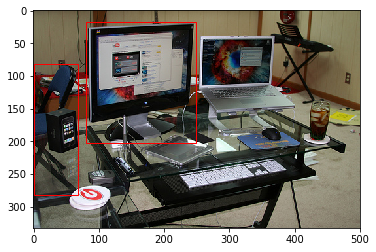

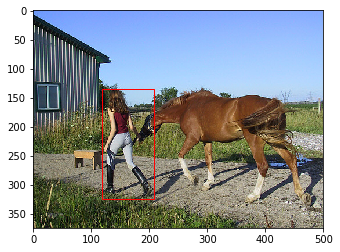

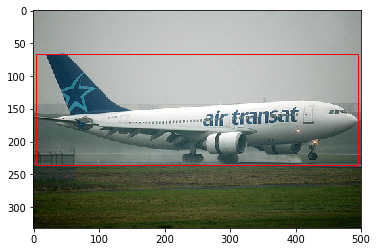

In [9]:
for i in range(3):
    i = np.random.randint(0, len(bboxes))
    im = images[i] #.transpose((1,2,0))
#     idx = np.where(image_names[i] == np.array(bbox_names))[0][0]
    bbox = np.array(bboxes[i])[:,1:]

    params = dict(linewidth=1,edgecolor='r',facecolor='none')
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)
    for box in bbox:
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = patches.Rectangle(box[:2], width, height, **params)
        ax.add_patch(rect)

    plt.show()

In [10]:
with open('./data/test.pickle', 'rb') as f:
    images, bboxes = pickle.load(f)

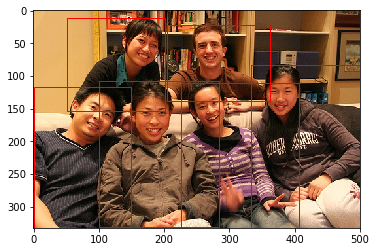

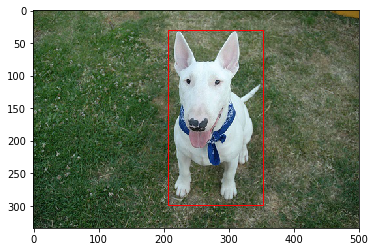

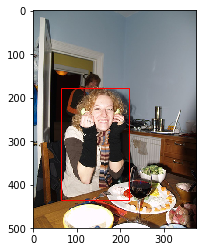

In [11]:
for i in range(3):
    i = np.random.randint(0, len(bboxes))
    im = images[i] #.transpose((1,2,0))
#     idx = np.where(image_names[i] == np.array(bbox_names))[0][0]
    bbox = np.array(bboxes[i])[:,1:]

    params = dict(linewidth=1,edgecolor='r',facecolor='none')
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)
    for box in bbox:
        width = box[2] - box[0]
        height = box[3] - box[1]
        rect = patches.Rectangle(box[:2], width, height, **params)
        ax.add_patch(rect)

    plt.show()